In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
path='C:/Users/mod96/Desktop/HSH/StudyingMaterials/Project - datascience/dataset'
seq_length=50
TARGET=2  #0: 종가 1: 시가 2: 고가 3: 저가

In [10]:
def datapreparation():
    data=pd.read_csv(open(path+'/005930.csv'))
    data.drop(['Unnamed: 0','전일비','날짜'],axis=1,inplace=True)
    data=data.reindex(index=data.index[::-1])
    
    return data


def FaceDivision(df):
    assert ~np.isnan(df.to_numpy()).any(), "there exist NaN in raw data"
    
    temp1=pd.DataFrame(df.to_numpy(),columns=df.columns)
    temp2=temp1.drop('거래량',axis=1)
    index1=list(temp1[temp1['거래량']==0].index) 
    
    #비인기주는 아무도 관심을 주지 않아(...) 거래량이 0인 경우도 있다.
    #또한 액면분할은 여러번 있을 수 있다.
    
    DivisionDays=[]
    for i in range(len(index1)-1):
        if index1[i+1]-index1[i] >1:
            DivisionDays.append(index1[:i+1])
            index1=index1[i+1:]
            
    DivisionDays.append(index1)
    
    for i in range(len(DivisionDays)):
        beforeDivision=temp2.loc[DivisionDays[i][0]-1,'종가']
        afterDivision=temp2.loc[DivisionDays[i][-1]+1,'시가']
        ratio=afterDivision/beforeDivision
        if 1/ratio>=1.5:                       #after 에 비해 before 가 1.5 배 이상이면 액면분할이라 가정
            temp2.loc[:DivisionDays[i][-1]]=temp2.loc[:DivisionDays[i][-1]]*ratio   #df의 slicing 은 거기까지 포함한다.
    
    return temp2

def Emptyfill(df):            #종가가 모두 존재한다는 가정 하에 시가/고가/저가 항목이 비어있으면 채워준다.
    temp=np.array(df.loc[:,'종가'])
    temp=np.where(temp==0,np.nan,temp)
    assert ~np.isnan(temp).any(), "there exist 0 in '종가' column"
    
    for item in ['시가','고가','저가']:
        index1=list(df[df[item].map(int)==0].index)
        for each in index1:
            df.loc[each,item]=df.loc[each,'종가']
    
    return df

def df2nps(df,seqlen):
    seq_len=seqlen+1
    temp=df.to_numpy()
    result=[]
    for i in range(df.shape[0]-seq_len):
        result.append( temp[i:i+seq_len,:] )
        
    return np.array(result)


def normalization_and_split(result,train_ratio,TARGET):
    denoms=[]
    for table in result:
        temp=[]
        for i in range(table.shape[1]):
            denominator=float(table[0,i])
            table[:,i]=(table[:,i]/denominator)-1
            temp.append(denominator)
        denoms.append(temp)
    denoms=np.array(denoms)

    #sklearn 에서 자동으로 섞어주는게 있는데 그것보단 순서 고려해서 쪼개는게 좋은듯
    ratio=int(round(len(result)*train_ratio))
    train=result[:ratio,:,:]
    np.random.shuffle(train)
    x_train=train[:,:-1,:]
    y_train=train[:,-1,TARGET]
    
    x_test=result[ratio:,:-1,:]
    y_test=result[ratio:,-1,TARGET]
    denoms=denoms[ratio:,TARGET]
    print("x_train shape :",x_train.shape,"y_train shape :",y_train.shape,
          "x_test shape :",x_test.shape,"y_test shape :",y_test.shape,"denoms :",denoms.shape)
    return x_train, y_train, x_test, y_test, denoms

def pred2realval(value,denoms):
    return (value+1)*denoms

def visualization(model,history,x_test,y_test,denoms):
    pred = model.predict(x_test)
    Ytest=(y_test+1)*denoms
    Ypred=(pred.reshape(pred.shape[0])+1)*denoms
    Ytest_pct=pd.Series(Ytest).pct_change().dropna()
    Ypred_pct=pd.Series(Ypred).pct_change().dropna()
    CORR=np.corrcoef(Ytest_pct.values,Ypred_pct.values)

    fig = plt.figure(facecolor='white', figsize=(15, 15))
    ax1 = fig.add_subplot(312)
    ax1.plot(Ytest, label='True')
    ax1.plot(Ypred, label='Prediction')
    ax1.legend()
    ax1.set_title('test prediction')

    ax2 = fig.add_subplot(321)
    ax2.plot(history.history[ 'loss' ])
    ax2.set_title( 'model loss' )
    ax2.set_ylabel( 'loss' )
    ax2.set_xlabel( 'epoch' )
    ax2.legend([ 'train'], loc= 'upper left' )

    ax3 = fig.add_subplot(322)
    ax3.plot(history.history[ 'accuracy' ])
    ax3.set_title( 'model accuracy' )
    ax3.set_ylabel( 'accuracy' )
    ax3.set_xlabel( 'epoch' )
    ax3.legend([ 'train' ], loc= 'upper left' )
    
    
    fig = plt.figure(facecolor='white', figsize=(15, 15))
    ax4 = fig.add_subplot(312)
    ax4.plot(Ytest_pct, label='True')
    ax4.plot(Ypred_pct, label='Prediction')
    ax4.legend()
    ax4.set_title('percentile prediction')

    plt.show()
    print("CorrelationCoef :",CORR)

data=Emptyfill(FaceDivision(datapreparation()))
result=df2nps(data,seq_length)
x_train, y_train, x_test, y_test, denoms = normalization_and_split(result,0.9,TARGET)

x_train shape : (5350, 50, 4) y_train shape : (5350,) x_test shape : (595, 50, 4) y_test shape : (595,) denoms : (595,)


Train on 5350 samples
Epoch 1/20
5350/5350 [==============================] - 31s 6ms/sample - loss: 0.0028 - accuracy: 0.0039
Epoch 2/20
5350/5350 [==============================] - 29s 5ms/sample - loss: 0.0012 - accuracy: 0.0039
Epoch 3/20
5350/5350 [==============================] - 30s 6ms/sample - loss: 8.4542e-04 - accuracy: 0.0039
Epoch 4/20
5350/5350 [==============================] - 29s 5ms/sample - loss: 7.1865e-04 - accuracy: 0.0039
Epoch 5/20
5350/5350 [==============================] - 29s 6ms/sample - loss: 7.1696e-04 - accuracy: 0.0039
Epoch 6/20
5350/5350 [==============================] - 30s 6ms/sample - loss: 6.4801e-04 - accuracy: 0.0039
Epoch 7/20
5350/5350 [==============================] - 29s 5ms/sample - loss: 6.5276e-04 - accuracy: 0.0039
Epoch 8/20
5350/5350 [==============================] - 29s 5ms/sample - loss: 6.2005e-04 - accuracy: 0.0039
Epoch 9/20
5350/5350 [==============================] - 29s 5ms/sample - loss: 6.3632e-04 - accuracy: 0.0039
Epoch

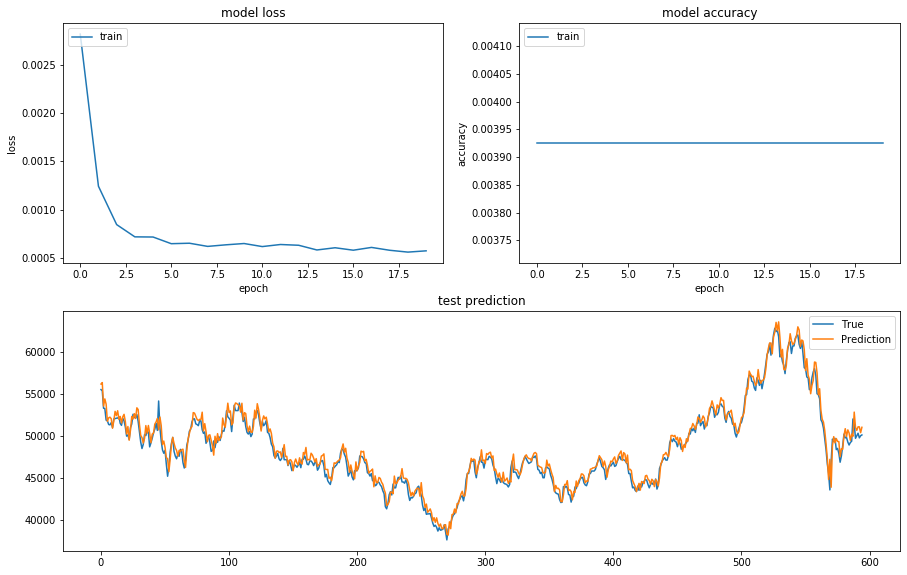

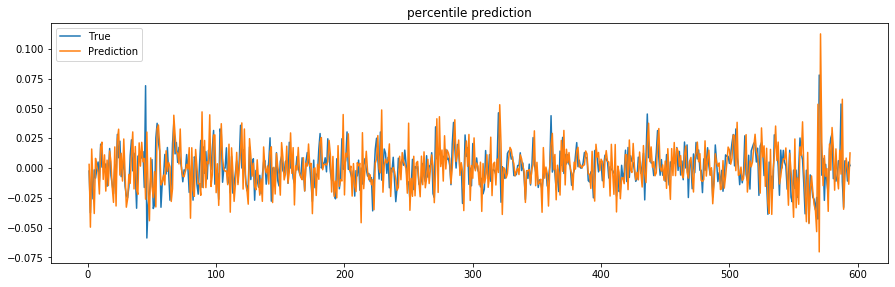

CorrelationCoef : [[1.         0.29932204]
 [0.29932204 1.        ]]


In [18]:
model=Sequential()  #LSTM, adam 이 그나마 나음.
model.add( layers.LSTM(50, return_sequences=True,input_shape=(50,4)) )
model.add( layers.LSTM(64, return_sequences=False))
model.add( layers.Dense(1, activation='linear'))
model.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])

history=model.fit(x_train,y_train,epochs=20,batch_size=10,verbose=1)
scores = model.evaluate(x_test, y_test) 
print("%s: %.5f%%" % (model.metrics_names[1], scores[1] * 100))
visualization(model,history,x_test,y_test,denoms)

In [ ]:
save_path='C:/Users/mod96/Desktop/HSH/StudyingMaterials/Project - datascience/models/'
KEY_index='005930'
model.save(save_path+KEY_index+'.h5')

불러오기
=======

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
path='C:/Users/mod96/Desktop/HSH/StudyingMaterials/Project - datascience/dataset'
seq_length=50
TARGET=2  #0: 종가 1: 시가 2: 고가 3: 저가

In [11]:
def visualization(model,x_test,y_test,denoms):
    pred = model.predict(x_test)
    Ytest=(y_test+1)*denoms
    Ypred=(pred.reshape(pred.shape[0])+1)*denoms
    Ytest_pct=pd.Series(Ytest).pct_change().dropna()
    Ypred_pct=pd.Series(Ypred).pct_change().dropna()
    CORR=np.corrcoef(Ytest_pct.values,Ypred_pct.values)

    fig = plt.figure(facecolor='white', figsize=(15, 15))
    ax1 = fig.add_subplot(211)
    ax1.plot(Ytest, label='True')
    ax1.plot(Ypred, label='Prediction')
    ax1.legend()
    ax1.set_title('test prediction')
    
    fig = plt.figure(facecolor='white', figsize=(15, 15))
    ax4 = fig.add_subplot(212)
    ax4.plot(Ytest_pct, label='True')
    ax4.plot(Ypred_pct, label='Prediction')
    ax4.legend()
    ax4.set_title('percentile prediction')

    plt.show()
    print("CorrelationCoef :",CORR)

In [2]:
save_path='C:/Users/mod96/Desktop/HSH/StudyingMaterials/Project - datascience/models/'
KEY_index='005930'
loaded=tf.keras.models.load_model(save_path+KEY_index+'.h5')

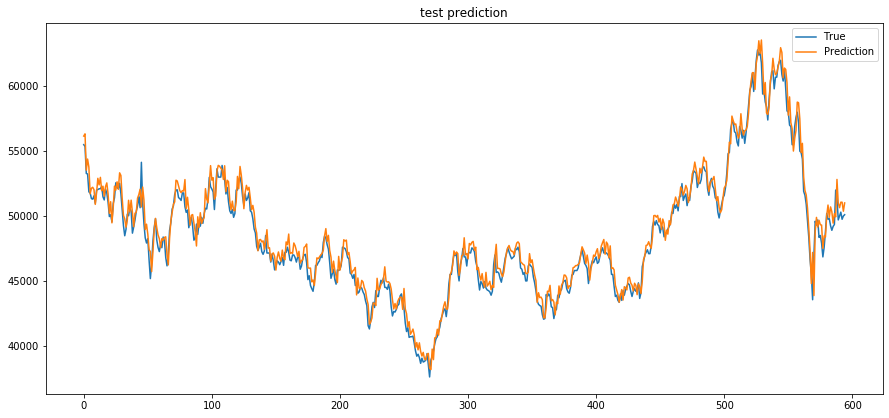

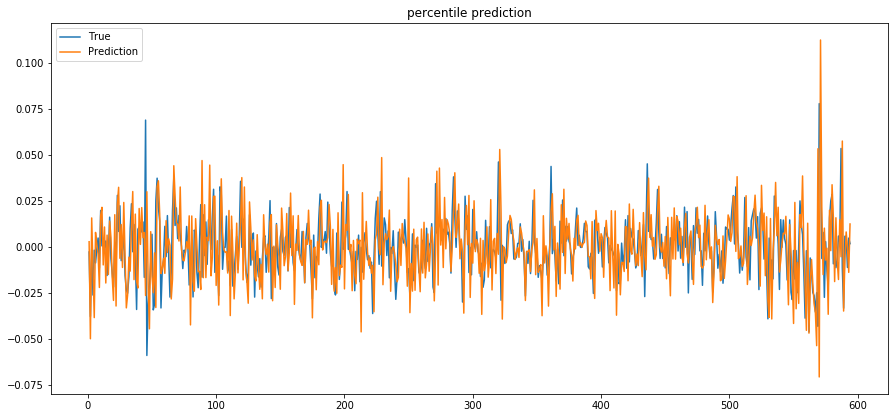

CorrelationCoef : [[1.         0.29932204]
 [0.29932204 1.        ]]


In [12]:
visualization(loaded,x_test,y_test,denoms)

In [35]:
def trustValue(model,history,x_test,y_test,denoms):
    pred = model.predict(x_test)
    Ytest=(y_test+1)*denoms
    Ypred=(pred.reshape(pred.shape[0])+1)*denoms
    Ytest_pct=pd.Series(Ytest).pct_change().dropna()
    Ypred_pct=pd.Series(Ypred).pct_change().dropna()
    CORR=np.corrcoef(Ytest_pct.values,Ypred_pct.values)

    return CORR[0,1]
trustValue(loaded,history,x_test,y_test,denoms)

0.29932203609468855

In [45]:
A=[1,2,3,6,7,8,10,11,12,50]
idx=[]
for i in range(len(A)-1):
    if A[i+1]-A[i]>1:
        idx.append(int(i))
idx.insert(0,-1)
D=[]
for i in range(len(idx)-1):
    D.append(A[idx[i]+1:idx[i+1]+1])
D.append(A[idx[-1]+1:])
D

[[1, 2, 3], [6, 7, 8], [10, 11, 12], [50]]